<a href="https://colab.research.google.com/github/dmitrykosintsev/dtc-traffic-sign-recognition/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0 Imports

In [52]:
# To get the data directly from Google Colab
import os
import cv2
import kagglehub
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from collections import defaultdict
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### 1 Dataset

In [2]:
# Download the dataset
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gtsrb-german-traffic-sign' dataset.
Path to dataset files: /kaggle/input/gtsrb-german-traffic-sign


In [3]:
image_path = "/kaggle/input/gtsrb-german-traffic-sign/Train/0"
image_name = "00000_00000_00000.png"
fullname = f'{image_path}/{image_name}'
fullname

'/kaggle/input/gtsrb-german-traffic-sign/Train/0/00000_00000_00000.png'

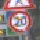

In [5]:
img = load_img(fullname, target_size=(40, 40))
img

### 2 Visualizing the dataset

In [7]:
# Function to analise the dataset
def analyze_folder(folder_path, sample_limit=None):
    """Analyze images in a folder and return statistics"""
    stats = {
        'widths': [],
        'heights': [],
        'aspect_ratios': [],
        'total_images': 0
    }

    # Walk through all subdirectories
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.ppm')):
                try:
                    img_path = os.path.join(root, file)
                    img = Image.open(img_path)
                    width, height = img.size

                    stats['widths'].append(width)
                    stats['heights'].append(height)
                    stats['aspect_ratios'].append(width / height)
                    stats['total_images'] += 1

                    if sample_limit and stats['total_images'] >= sample_limit:
                        break
                except Exception as e:
                    print(f"Error reading {img_path}: {e}")

        if sample_limit and stats['total_images'] >= sample_limit:
            break

    return stats

In [8]:
# Function to visualize the sizes of images
def visualize_distributions(train_stats, test_stats):
    """Create visualizations of image size distributions"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Width distributions
    axes[0, 0].hist(train_stats['widths'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].set_title('Train: Width Distribution')
    axes[0, 0].set_xlabel('Width (px)')
    axes[0, 0].set_ylabel('Frequency')

    axes[1, 0].hist(test_stats['widths'], bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[1, 0].set_title('Test: Width Distribution')
    axes[1, 0].set_xlabel('Width (px)')
    axes[1, 0].set_ylabel('Frequency')

    # Height distributions
    axes[0, 1].hist(train_stats['heights'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 1].set_title('Train: Height Distribution')
    axes[0, 1].set_xlabel('Height (px)')
    axes[0, 1].set_ylabel('Frequency')

    axes[1, 1].hist(test_stats['heights'], bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[1, 1].set_title('Test: Height Distribution')
    axes[1, 1].set_xlabel('Height (px)')
    axes[1, 1].set_ylabel('Frequency')

    # Aspect ratio distributions
    axes[0, 2].hist(train_stats['aspect_ratios'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 2].set_title('Train: Aspect Ratio Distribution')
    axes[0, 2].set_xlabel('Aspect Ratio')
    axes[0, 2].set_ylabel('Frequency')

    axes[1, 2].hist(test_stats['aspect_ratios'], bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[1, 2].set_title('Test: Aspect Ratio Distribution')
    axes[1, 2].set_xlabel('Aspect Ratio')
    axes[1, 2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.savefig('gtsrb_size_analysis.png', dpi=100, bbox_inches='tight')
    plt.show()


Analyzing TRAIN folder...

Analyzing TEST folder...

Analyzing META folder...

Generating visualizations...


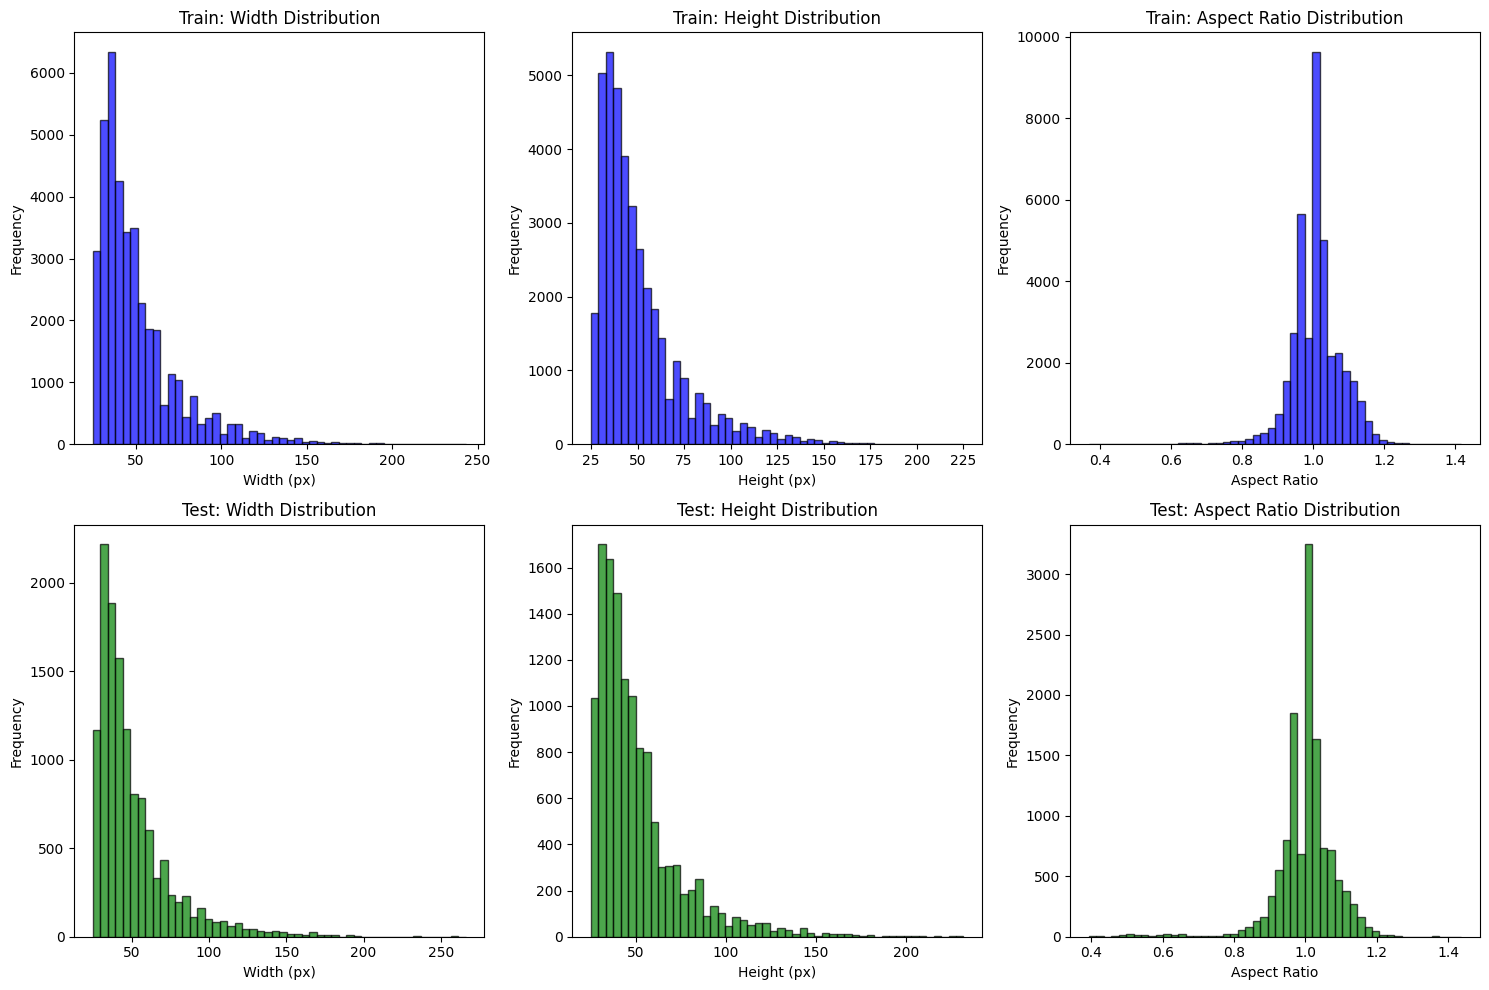

In [9]:
# Analyze train folder
train_path = os.path.join(path, 'train')
if os.path.exists(train_path):
    print("\nAnalyzing TRAIN folder...")
    train_stats = analyze_folder(train_path)
else:
    print(f"Train folder not found at {train_path}")
    train_stats = None

# Analyze test folder
test_path = os.path.join(path, 'test')
if os.path.exists(test_path):
    print("\nAnalyzing TEST folder...")
    test_stats = analyze_folder(test_path)
else:
    print(f"Test folder not found at {test_path}")
    test_stats = None

# Analyze meta folder
meta_path = os.path.join(path, 'meta')
if os.path.exists(meta_path):
    print("\nAnalyzing META folder...")
    meta_stats = analyze_folder(meta_path)

# Visualize if we have both train and test stats
if train_stats and test_stats:
    print("\nGenerating visualizations...")
    visualize_distributions(train_stats, test_stats)

In [10]:
# Assigning human-readable names to classes found in the csv files
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

In [14]:
# Analyse the class distribution and visualize the most common classes
def class_count(path, classes):
  train_path = path + "/train"
  # Count images in each class folder
  class_counts = {}

  for class_id in range(43):  # 0 to 42
    class_folder = os.path.join(train_path, str(class_id))

    if os.path.exists(class_folder):
        # Count image files in the folder
        image_files = [f for f in os.listdir(class_folder)
                      if f.lower().endswith(('.png'))]
        class_counts[class_id] = len(image_files)
    else:
        class_counts[class_id] = 0
        print(f"Warning: Folder for class {class_id} not found")

  # Create DataFrame for better analysis
  df = pd.DataFrame({
      'Class ID': list(class_counts.keys()),
      'Class Name': [classes[i] for i in class_counts.keys()],
      'Count': list(class_counts.values())
  })

  # Sort by count
  df_sorted = df.sort_values('Count', ascending=False)

  # Create visualizations
  fig, axes = plt.subplots(2, 2, figsize=(16, 12))

  # 1. Bar plot - all classes ordered by class ID
  ax1 = axes[0, 0]
  bars1 = ax1.bar(df['Class ID'], df['Count'], color='steelblue', edgecolor='black', alpha=0.7)
  ax1.set_xlabel('Class ID', fontsize=12, fontweight='bold')
  ax1.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
  ax1.set_title('Distribution by Class ID', fontsize=14, fontweight='bold')
  ax1.grid(axis='y', alpha=0.3, linestyle='--')
  ax1.set_xticks(range(0, 43, 2))

  # 2. Bar plot - sorted by count
  ax2 = axes[0, 1]
  bars2 = ax2.barh(range(len(df_sorted)), df_sorted['Count'], color='coral', edgecolor='black', alpha=0.7)
  ax2.set_yticks(range(len(df_sorted)))
  ax2.set_yticklabels([f"{row['Class ID']}" for _, row in df_sorted.iterrows()], fontsize=8)
  ax2.set_xlabel('Number of Images', fontsize=12, fontweight='bold')
  ax2.set_ylabel('Class ID', fontsize=12, fontweight='bold')
  ax2.set_title('Distribution Sorted by Count', fontsize=14, fontweight='bold')
  ax2.grid(axis='x', alpha=0.3, linestyle='--')
  ax2.invert_yaxis()

  # 3. Histogram of distribution
  ax3 = axes[1, 0]
  ax3.hist(df['Count'], bins=20, color='seagreen', edgecolor='black', alpha=0.7)
  ax3.set_xlabel('Number of Images per Class', fontsize=12, fontweight='bold')
  ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
  ax3.set_title('Histogram of Class Sizes', fontsize=14, fontweight='bold')
  ax3.axvline(df['Count'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["Count"].mean():.0f}')
  ax3.axvline(df['Count'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df["Count"].median():.0f}')
  ax3.legend()
  ax3.grid(axis='y', alpha=0.3, linestyle='--')

  # 4. Top 10 classes with labels
  ax4 = axes[1, 1]
  top10 = df_sorted.head(10)
  bars4 = ax4.barh(range(len(top10)), top10['Count'], color='mediumpurple', edgecolor='black', alpha=0.7)
  ax4.set_yticks(range(len(top10)))
  ax4.set_yticklabels([f"{row['Class ID']}: {row['Class Name'][:25]}" for _, row in top10.iterrows()], fontsize=9)
  ax4.set_xlabel('Number of Images', fontsize=12, fontweight='bold')
  ax4.set_title('Top 10 Most Common Classes', fontsize=14, fontweight='bold')
  ax4.grid(axis='x', alpha=0.3, linestyle='--')
  ax4.invert_yaxis()

  # Add value labels on bars
  for i, bar in enumerate(bars4):
      width = bar.get_width()
      ax4.text(width, bar.get_y() + bar.get_height()/2, f' {int(width)}',
              ha='left', va='center', fontsize=9, fontweight='bold')

  plt.tight_layout()
  plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
  plt.show()

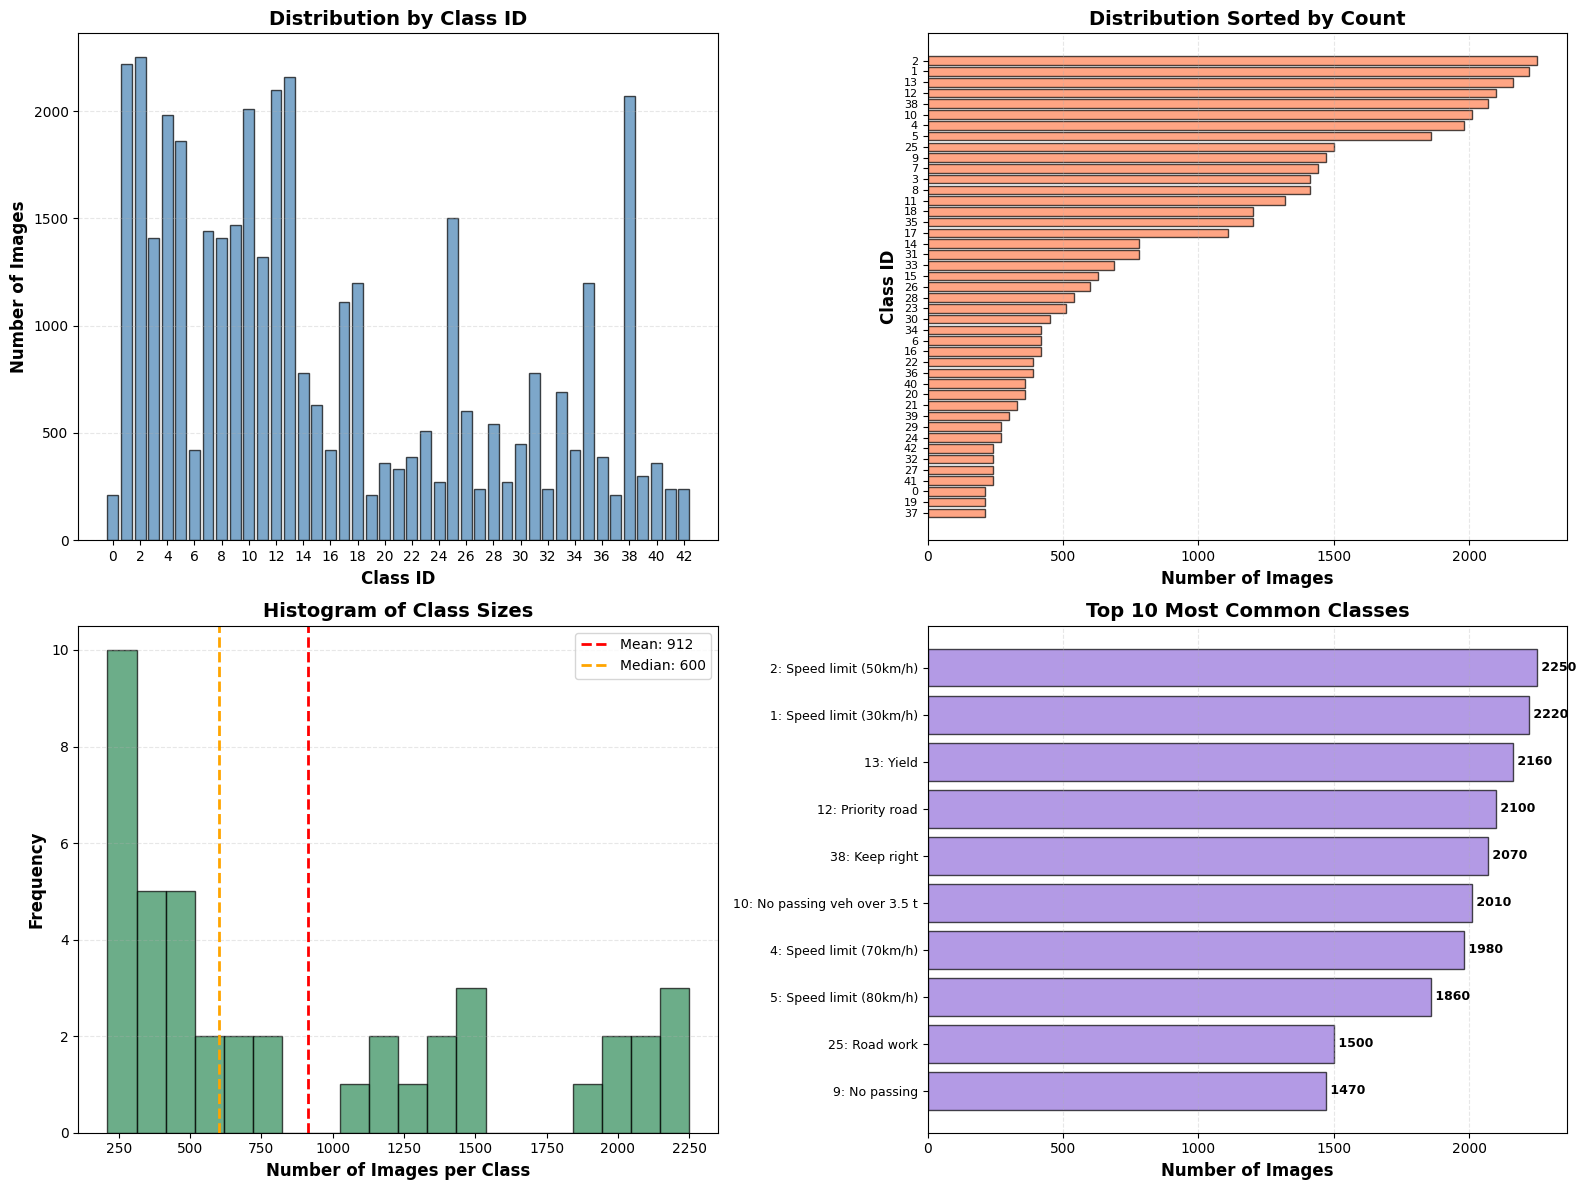

In [13]:
class_count(path=path, classes=classes)

In [15]:
# Display 25 random images from the test set
def image_check(path):
  image_path = path + "/test"

  # Collect all image paths from test folder
  image_paths = []

  for root, dirs, files in os.walk(test_path):
      for file in files:
          if file.lower().endswith(('.png', '.jpg', '.jpeg', '.ppm')):
              image_paths.append(os.path.join(root, file))

  print(f"Total images found in test folder: {len(image_paths)}")

  # Randomly select 25 images
  num_images = min(25, len(image_paths))
  selected_images = random.sample(image_paths, num_images)

  print(f"Visualizing {num_images} random images...")

  # Create a 5x5 grid
  fig, axes = plt.subplots(5, 5, figsize=(10, 10))
  fig.suptitle('25 Random Images from Test Set (25x25)', fontsize=14, fontweight='bold')

  # Flatten axes for easier iteration
  axes = axes.flatten()

  # Display images
  for idx, img_path in enumerate(selected_images):
      try:
          # Load and resize image to 25x25
          img = Image.open(img_path)
          img_resized = img.resize((25, 25))

          # Display image
          axes[idx].imshow(img_resized)
          axes[idx].axis('off')

      except Exception as e:
          print(f"Error loading image {img_path}: {e}")
          axes[idx].axis('off')

  plt.tight_layout()
  plt.savefig('test_images_sample.png', dpi=150, bbox_inches='tight')
  plt.show()

  print("Visualization complete!")

Total images found in test folder: 12630
Visualizing 25 random images...


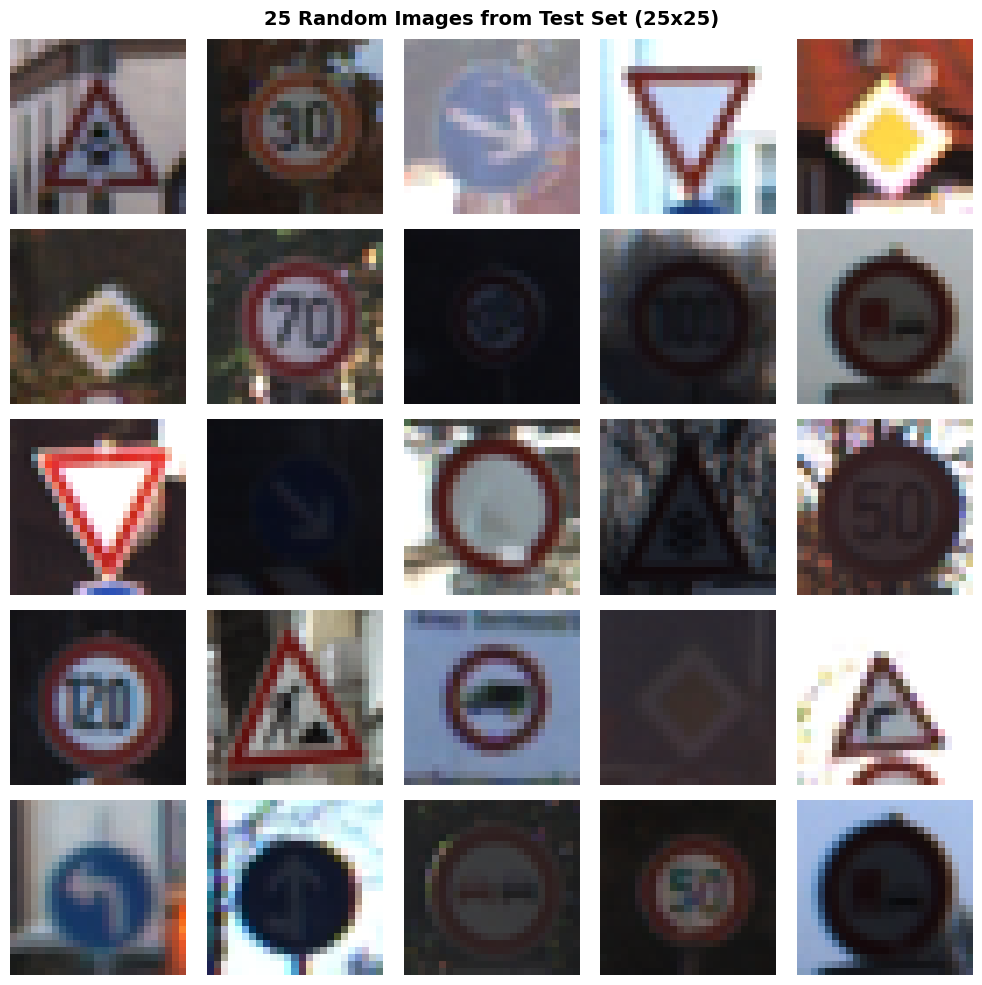

Visualization complete!


In [18]:
image_check(path)

### 3 Loading data and splitting into train and val

In [35]:
# Loading the dataset as numpy arrays and splitting the data
def load_gtsrb_data(path, img_height=30, img_width=30,
                    validation_split=0.3, shuffle=True, random_state=42):
    """
    Efficiently load and preprocess GTSRB training data.

    Parameters:
    -----------
    path : str
        Path to the data directory
    img_height : int
        Target height for resized images
    img_width : int
        Target width for resized images
    validation_split : float
        Fraction of data to use for validation (0.0 to 1.0)
    shuffle : bool
        Whether to shuffle the data before splitting
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    X_train, X_val, y_train, y_val : numpy arrays
        Training and validation data and labels (shuffled if shuffle=True)
    """

    train_path = path + "/train"

    # Get number of categories
    num_categories = len([d for d in os.listdir(train_path)
                         if os.path.isdir(os.path.join(train_path, d))])

    print(f"Found {num_categories} categories")

    # First pass: count total images for efficient array allocation
    total_images = 0
    for i in range(num_categories):
        class_path = os.path.join(train_path, str(i))
        if os.path.exists(class_path):
            total_images += len([f for f in os.listdir(class_path)
                               if f.lower().endswith(('.png'))])

    print(f"Total images to load: {total_images}")

    # Pre-allocate arrays (much more efficient than list appending)
    image_data = np.zeros((total_images, img_height, img_width, 3), dtype=np.uint8)
    image_labels = np.zeros(total_images, dtype=np.int32)

    # Load images with progress bar
    idx = 0
    failed_images = []

    with tqdm(total=total_images, desc="Loading images") as pbar:
        for class_id in range(num_categories):
            class_path = os.path.join(train_path, str(class_id))

            if not os.path.exists(class_path):
                print(f"Warning: Class {class_id} directory not found")
                continue

            images = [f for f in os.listdir(class_path)
                     if f.lower().endswith(('.png'))]

            for img_name in images:
                img_path = os.path.join(class_path, img_name)

                try:
                    # Read image directly with cv2 (BGR format)
                    image = cv2.imread(img_path)

                    if image is None:
                        raise ValueError(f"Failed to load image")

                    # Convert BGR to RGB
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    # Resize with better interpolation
                    image_resized = cv2.resize(image, (img_width, img_height),
                                              interpolation=cv2.INTER_AREA)

                    # Store in pre-allocated array
                    image_data[idx] = image_resized
                    image_labels[idx] = class_id
                    idx += 1

                except Exception as e:
                    failed_images.append((img_path, str(e)))

                pbar.update(1)

    # Trim arrays if some images failed to load
    if idx < total_images:
        image_data = image_data[:idx]
        image_labels = image_labels[:idx]
        print(f"Warning: {total_images - idx} images failed to load")

    # Report failures
    if failed_images:
        print(f"\nFailed to load {len(failed_images)} images:")
        for path, error in failed_images[:5]:  # Show first 5
            print(f"  {path}: {error}")
        if len(failed_images) > 5:
            print(f"  ... and {len(failed_images) - 5} more")

    print(f"\nSuccessfully loaded: {len(image_data)} images")
    print(f"Data shape: {image_data.shape}")
    print(f"Labels shape: {image_labels.shape}")
    print(f"Memory usage: {image_data.nbytes / (1024**2):.2f} MB")

    # Shuffle data if requested (even without validation split)
    if shuffle and validation_split == 0:
        print("\nShuffling data...")
        np.random.seed(random_state)
        shuffle_indices = np.random.permutation(len(image_data))
        image_data = image_data[shuffle_indices]
        image_labels = image_labels[shuffle_indices]

    # Split into train and validation sets
    if validation_split > 0:
        X_train, X_val, y_train, y_val = train_test_split(
            image_data, image_labels,
            test_size=validation_split,
            random_state=random_state,
            shuffle=shuffle,  # Explicitly control shuffling
            stratify=image_labels  # Maintains class distribution
        )

        print(f"\nTrain set: {len(X_train)} images")
        print(f"Validation set: {len(X_val)} images")

        X_train_normalized = X_train.astype('float32') / 255.0
        X_val_normalized = X_val.astype('float32') / 255.0

        return X_train, X_val, y_train, y_val, X_train_normalized, X_val_normalized
    else:
        return image_data, None, image_labels, None, None, None

In [36]:
# Load and split data using default parameters
X_train, X_val, y_train, y_val, X_train_normalized, X_val_normalized = load_gtsrb_data(path)

Found 43 categories
Total images to load: 39209


Loading images: 100%|██████████| 39209/39209 [00:37<00:00, 1053.35it/s]



Successfully loaded: 39209 images
Data shape: (39209, 30, 30, 3)
Labels shape: (39209,)
Memory usage: 100.96 MB

Train set: 27446 images
Validation set: 11763 images


In [37]:
print("X_train.shape", X_train.shape)
print("X_val.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_val.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_val.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_val.shape (11763,)


### 4 One-hot encoding for labels

In [38]:
y_train = keras.utils.to_categorical(y_train, 43)
y_val = keras.utils.to_categorical(y_val, 43)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


### 5 Create the model

In [45]:
def create_cnn_model(input_shape=(30, 30, 3), num_classes=43):
    """
    Create a CNN model for GTSRB traffic sign classification.

    This architecture is inspired by successful GTSRB submissions and includes:
    - Multiple convolutional layers for feature extraction
    - Batch normalization for stable training
    - Dropout for regularization
    - Dense layers for classification

    Parameters:
    -----------
    input_shape : tuple
        Shape of input images (height, width, channels)
    num_classes : int
        Number of traffic sign classes (43 for GTSRB)

    Returns:
    --------
    model : keras.Model
        Compiled CNN model ready for training
    """

    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [46]:
# Create the model with defaul parameters
model = create_cnn_model(input_shape=(30, 30, 3), num_classes=43)

In [47]:
# Display model architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,024,587 (3.91 MB)

 Trainable params: 1,022,155 (3.90 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [48]:
# Calculate total parameters
total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")


Total parameters: 1,024,587


In [49]:
# Setup callbacks for training
callbacks = [
    # Stop training if validation loss doesn't improve for 10 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    # Save the best model
    ModelCheckpoint(
        'best_gtsrb_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

### 6 Model training

In [50]:
# Normalize pixel values
X_train_normalized = X_train.astype('float32') / 255.0
X_val_normalized = X_val.astype('float32') / 255.0

history = model.fit(
    X_train_normalized, y_train,
    validation_data=(X_val_normalized, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    shuffle=True,  # Shuffle each epoch
    verbose=1
)

Epoch 1/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2327 - loss: 3.2931
Epoch 1: val_accuracy improved from -inf to 0.70739, saving model to best_gtsrb_model.h5


429/429 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.2332 - loss: 3.2905 - val_accuracy: 0.7074 - val_loss: 1.0148 - learning_rate: 0.0010
Epoch 2/50
426/429 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8163 - loss: 0.5860
Epoch 2: val_accuracy improved from 0.70739 to 0.97798, saving model to best_gtsrb_model.h5


429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8167 - loss: 0.5848 - val_accuracy: 0.9780 - val_loss: 0.0809 - learning_rate: 0.0010
Epoch 3/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9379 - loss: 0.2044
Epoch 3: val_accuracy improved from 0.97798 to 0.98521, saving model to best_gtsrb_model.h5


429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9380 - loss: 0.2043 - val_accuracy: 0.9852 - val_loss: 0.0490 - learning_rate: 0.0010
Epoch 4/50
423/429 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9627 - loss: 0.1277
Epoch 4: val_accuracy improved from 0.98521 to 0.98674, saving model to best_gtsrb_model.h5


429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9628 - loss: 0.1275 - val_accuracy: 0.9867 - val_loss: 0.0415 - learning_rate: 0.0010
Epoch 5/50
423/429 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9748 - loss: 0.0828
Epoch 5: val_accuracy improved from 0.98674 to 0.99498, saving model to best_gtsrb_model.h5


429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9748 - loss: 0.0827 - val_accuracy: 0.9950 - val_loss: 0.0178 - learning_rate: 0.0010
Epoch 6/50
425/429 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9824 - loss: 0.0578
Epoch 6: val_accuracy improved from 0.99498 to 0.99626, saving model to best_gtsrb_model.h5


429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9824 - loss: 0.0578 - val_accuracy: 0.9963 - val_loss: 0.0117 - learning_rate: 0.0010
Epoch 7/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9871 - loss: 0.0419
Epoch 7: val_accuracy did not improve from 0.99626
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9871 - loss: 0.0419 - val_accuracy: 0.9941 - val_loss: 0.0182 - learning_rate: 0.0010
Epoch 8/50
423/429 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9841 - loss: 0.0515
Epoch 8: val_accuracy did not improve from 0.99626
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9841 - loss: 0.0515 - val_accuracy: 0.9956 - val_loss: 0.0154 - learning_rate: 0.0010
Epoch 9/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9858 - loss: 0.0445
Epoch 9: val_accuracy did not improve from 0.99626
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9858 - loss: 0.0445 - val_accuracy: 0.9946 - val_loss: 0.0160 - learning_rate: 0.0010
Epoch 10/50
423/429 ━

429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9890 - loss: 0.0332 - val_accuracy: 0.9973 - val_loss: 0.0101 - learning_rate: 0.0010
Epoch 11/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9898 - loss: 0.0355
Epoch 11: val_accuracy did not improve from 0.99728
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9898 - loss: 0.0355 - val_accuracy: 0.9934 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 12/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9891 - loss: 0.0332
Epoch 12: val_accuracy did not improve from 0.99728
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9891 - loss: 0.0332 - val_accuracy: 0.9972 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 13/50
425/429 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9910 - loss: 0.0288
Epoch 13: val_accuracy did not improve from 0.99728
429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9909 - loss: 0.0289 - val_accuracy: 0.9897 - val_loss: 0.0381 - learning_rate: 0.0010
Epoch 14/50
424/

429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9887 - loss: 0.0354 - val_accuracy: 0.9974 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 15/50
424/429 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9912 - loss: 0.0285
Epoch 15: val_accuracy improved from 0.99736 to 0.99762, saving model to best_gtsrb_model.h5


429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9912 - loss: 0.0285 - val_accuracy: 0.9976 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 16/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9939 - loss: 0.0222
Epoch 16: val_accuracy did not improve from 0.99762
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9939 - loss: 0.0222 - val_accuracy: 0.9966 - val_loss: 0.0109 - learning_rate: 0.0010
Epoch 17/50
425/429 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9925 - loss: 0.0238
Epoch 17: val_accuracy did not improve from 0.99762
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9925 - loss: 0.0238 - val_accuracy: 0.9962 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 18/50
428/429 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9921 - loss: 0.0242
Epoch 18: val_accuracy did not improve from 0.99762
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9921 - loss: 0.0242 - val_accuracy: 0.9976 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 19/50
425/4

429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9958 - loss: 0.0143 - val_accuracy: 0.9982 - val_loss: 0.0066 - learning_rate: 5.0000e-04
Epoch 22/50
425/429 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9973 - loss: 0.0090
Epoch 22: val_accuracy improved from 0.99821 to 0.99872, saving model to best_gtsrb_model.h5


429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9973 - loss: 0.0090 - val_accuracy: 0.9987 - val_loss: 0.0064 - learning_rate: 5.0000e-04
Epoch 23/50
424/429 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9988 - loss: 0.0045
Epoch 23: val_accuracy did not improve from 0.99872
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9988 - loss: 0.0045 - val_accuracy: 0.9987 - val_loss: 0.0058 - learning_rate: 5.0000e-04
Epoch 24/50
425/429 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9979 - loss: 0.0066
Epoch 24: val_accuracy did not improve from 0.99872
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9979 - loss: 0.0066 - val_accuracy: 0.9980 - val_loss: 0.0073 - learning_rate: 5.0000e-04
Epoch 25/50
428/429 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9984 - loss: 0.0067
Epoch 25: val_accuracy improved from 0.99872 to 0.99881, saving model to best_gtsrb_model.h5


429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9984 - loss: 0.0067 - val_accuracy: 0.9988 - val_loss: 0.0062 - learning_rate: 5.0000e-04
Epoch 26/50
424/429 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9987 - loss: 0.0046
Epoch 26: val_accuracy did not improve from 0.99881
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9987 - loss: 0.0046 - val_accuracy: 0.9985 - val_loss: 0.0068 - learning_rate: 5.0000e-04
Epoch 27/50
423/429 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9981 - loss: 0.0063
Epoch 27: val_accuracy did not improve from 0.99881
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9981 - loss: 0.0063 - val_accuracy: 0.9980 - val_loss: 0.0099 - learning_rate: 5.0000e-04
Epoch 28/50
423/429 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9977 - loss: 0.0066
Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 28: val_accuracy did not improve from 0.99881
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9977 - loss: 

429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9987 - loss: 0.0058 - val_accuracy: 0.9993 - val_loss: 0.0052 - learning_rate: 2.5000e-04
Epoch 30/50
423/429 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9986 - loss: 0.0045
Epoch 30: val_accuracy did not improve from 0.99932
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9986 - loss: 0.0045 - val_accuracy: 0.9991 - val_loss: 0.0059 - learning_rate: 2.5000e-04
Epoch 31/50
427/429 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9987 - loss: 0.0032
Epoch 31: val_accuracy did not improve from 0.99932
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9987 - loss: 0.0032 - val_accuracy: 0.9991 - val_loss: 0.0049 - learning_rate: 2.5000e-04
Epoch 32/50
423/429 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9994 - loss: 0.0016
Epoch 32: val_accuracy did not improve from 0.99932
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9994 - loss: 0.0017 - val_accuracy: 0.9986 - val_loss: 0.0060 - learning_rate: 2.5000e-04


429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9994 - loss: 0.0019 - val_accuracy: 0.9995 - val_loss: 0.0039 - learning_rate: 2.5000e-04
Epoch 35/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0011
Epoch 35: val_accuracy did not improve from 0.99949
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 0.9991 - val_loss: 0.0045 - learning_rate: 2.5000e-04
Epoch 36/50
425/429 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9993 - loss: 0.0022
Epoch 36: val_accuracy did not improve from 0.99949
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9993 - loss: 0.0022 - val_accuracy: 0.9995 - val_loss: 0.0032 - learning_rate: 2.5000e-04
Epoch 37/50
425/429 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0024
Epoch 37: val_accuracy did not improve from 0.99949
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9992 - loss: 0.0024 - val_accuracy: 0.9992 - val_loss: 0.0055 - learning_rate: 2.5000e-04
E

### 7 Model evaluation


Final Evaluation
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9995 - loss: 0.0028
Validation Loss: 0.0032
Validation Accuracy: 0.9995 (99.95%)


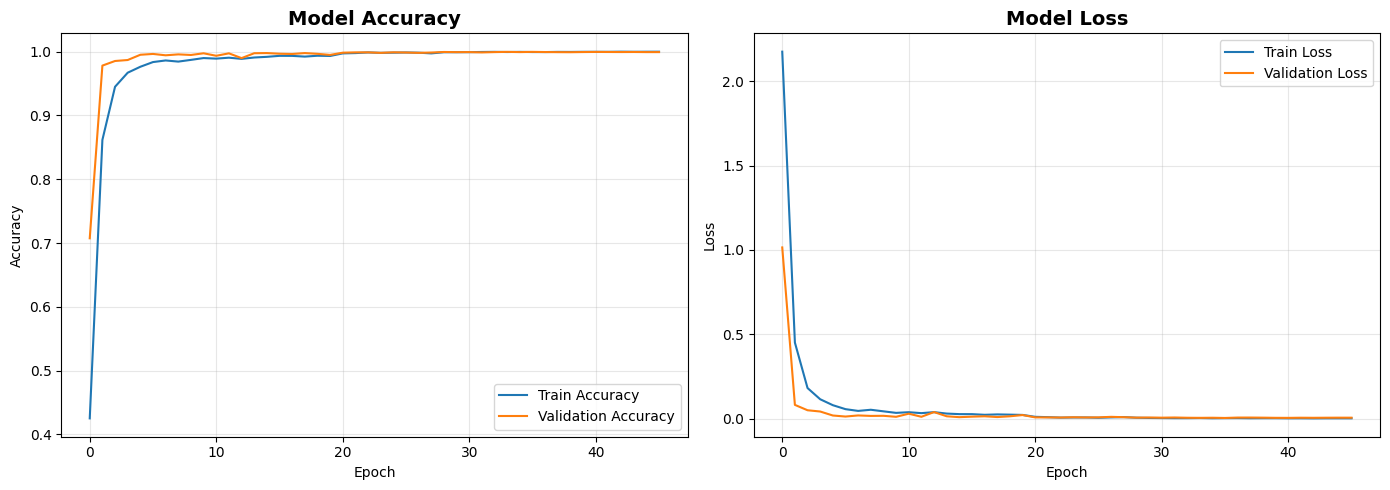


Training complete! Model saved as 'best_gtsrb_model.h5'


In [51]:
# Evaluate on validation set
print("\n" + "="*60)
print("Final Evaluation")
print("="*60)
val_loss, val_accuracy = model.evaluate(X_val_normalized, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

# Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

print("\n" + "="*60)
print("Training complete! Model saved as 'best_gtsrb_model.h5'")
print("="*60)

### Running the model on the test dataset

In [55]:
test = pd.read_csv(path + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(path + '/' +img)
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((30, 30))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test_normalized = X_test/255

# Use model.predict() and np.argmax() instead of the deprecated predict_classes()
pred = np.argmax(model.predict(X_test_normalized), axis=-1)

#Accuracy with the test data
print('Test Data accuracy: ', accuracy_score(labels, pred)*100)

/tmp/ipython-input-3220161271.py:13: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image_fromarray = Image.fromarray(image, 'RGB')


395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Test Data accuracy:  98.21060965954076
